# GLM-HMM with Input Driven Observations and Transitions

This notebook is written by Zeinab Mohammadi. Here, a class called "HMM_TO" is defined which contains GLM-HMM with Input-Driven Observations and Transitions. We used a HMM enriched with two sets of per-state GLM. These GLMs consist of a Bernoulli GLM, which models observations (mice choices), and a multinomial GLM, which handles transitions between different states. This sophisticated framework effectively captures the dynamic interplay between covariates, mouse choices, and state transitions. As a result, it offers a more refined description of behavioral activity when compared to classical models. 

Therefore, within the context of our model, we define two sets of covariates: $\mathbf{U}^{ob}={u}^{ob}_{1}, ..., {u}^{ob}_{T}$ represents the observation covariates, and $\mathbf{U}^{tr}={u}^{tr}_{1}, ..., {u}^{tr}_{T}$ represents the transition covariates where $T$ is the number of considered trials. Here, the input at each trial has a size of ${M}_{obs}$ for the observation model and ${M}_{tran}$ for the transition model. Additionally, we have a set of latent states denoted as $\mathbf{Z}={z}_{1}, ..., {z}_{T} $, and corresponding observations for these states denoted as $\mathbf{Y}={y}_{1}, ..., {y}_{T}$. For more detailed information about the model, please refer to our paper at [change this with the paper link](...) 

If you have any questions, please do not hesitate to contact me at <ins>zm6112 at princeton dot edu</ins>. Your engagement and feedback are highly appreciated for the improvement of this work.

##  Bernoulli GLM for observation

We employed a Bernoulli GLM to map the binary values of the animal's decision to a set of covariates. These weights serve to depict how the inputs of the model (e.g., stimulus features) influence the output (i.e., the animal's choice on each trial). The logit link function stands as the most widely adopted link function for a 2AFC choice GLM, and it can be expressed as $log(p/(1-p)) = F * \beta$, where $F$ corresponds to a design matrix, and $\beta$ represents a vector of coefficients. 

Consequently, we can describe an observational GLM using the following equation, where the animal choice at trial $t$, denoted by $y_{t}$, can take a value of 1 or 0, indicating the mouse turning the wheel to the right-side or left-side, respectively:

$$
\begin{align}
\Pr(y_t \mid z_{t} = k, u_{t}^{ob}) = 
\frac{\exp\{(w_{kt}^{ob})^\mathsf{T} u_{t}^{ob} \}}
{1+\exp\{(w_{kt}^{ob})^\mathsf{T} u_{t}^{ob} \}}
\end{align}
$$

In this equation, the presented GLM is associated with the observation covariates, $u_{t}^{ob} \in \mathbb{R}^{{M}_{obs}}$, and observation weights $w_{kt}^{ob}$ at trial $t$ and state $z_{t} = k$.

##  Multinomial GLM for transition

The multinomial GLM is an extension of the Generalized Linear Model, specifically designed to handle data with multiple categories. It's also known as softmax regression or the maximum entropy classifier. Unlike logistic regression, which deals with binary outcomes, multinomial GLMs can simultaneously analyze data from multiple categories. They establish relationships between independent variables and categorical dependent variables, enabling the determination of the likelihood associated with each category.

We explore the GLM-HMM with multinomial GLM outputs, a method for estimating the likelihood of the next state. In this framework, each state is equipped with a multinomial GLM, allowing it to model the complex relationship between transition covariates $u_{t}^{tr} \in \mathbb{R}^{{M}_{tran}}$, such as previous choice and reward, and the corresponding transition probabilities. This can be written as:

$$
\begin{align}
\Pr(z_t=k \mid u_{t}^{tr}) = 
\frac{\exp\{(w_{kt}^{tr})^\mathsf{T} u_{t}^{tr} \}}
{\sum_{j=1}^{K} \exp\{(w_{jt}^{tr})^\mathsf{T} u_{t}^{tr} \}}
\end{align}
$$

where $w_{jt}^{tr}$ corresponds to the transition weights associated with j-th state at trial $t$ and $K$ represents the total number of states. 

## 1. Setup
The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting. 

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
import random
import pandas as pd
import seaborn as sns
from ssm.util import find_permutation

%matplotlib inline
npr.seed(0)

In [2]:
# Set the parameters of the GLM-HMM framework
time_bins = 5000      # number of data points
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim_T = 2       # Transition input dimensions
input_dim_O = 2       # Observation input dimensions

# 2. Defining matrices of regressors for the model

Here, we generate two design matrices, one for observation and one for transition regressors. Within each matrix, a column represents a covariate. These covariates may include elements such as past choices or past stimuli, which are deemed pivotal in influencing the animal's decision-making process.

In [3]:
# Specifying the regressors (past choice, past stimuli, etc.)
inpt_pc = np.array(random.choices([-1, 1], k=time_bins)) 
inpt_wsls = np.array(random.choices([-1, 1], k=time_bins)) 
print('inpt_pc=', inpt_pc)
print('inpt_wsls=', inpt_wsls)

inpt_pc= [ 1 -1 -1 ...  1  1  1]
inpt_wsls= [ 1 -1  1 ... -1  1 -1]


# 2a. Designing input matrix for Transition 
In this section, we define the inputs for the transition matrix. While we're illustrating a simple case here, these specific regressors play a pivotal role in the transitions between different states within the GLM-HMM. To exemplify the inclusion of time and history in the regressors, we have applied an exponential filter to the transition regressors.

In [4]:
design_mat_T = np.zeros((time_bins, input_dim_T)) # transition design matrix

In [5]:
# Creating an exponential filter for the transition regressors
def ewma_time_series(values, period): 
    df_ewma = pd.DataFrame(data=np.array(values))
    ewma_data = df_ewma.ewm(span=period)
    ewma_data_mean = ewma_data.mean()
    return ewma_data_mean

Taus = [5] # time constant for the exponential filter
add = np.array(Taus).shape[0]

for i, tau in enumerate(Taus):
    design_mat_T[:, i] = ewma_time_series(inpt_pc, tau)[0] 
    
for i, tau in enumerate(Taus):
    design_mat_T[:, i+add] = ewma_time_series(inpt_wsls, tau)[0] 

transition_input = design_mat_T
print('design_mat_T=', design_mat_T)

design_mat_T= [[ 1.          1.        ]
 [-0.2        -0.2       ]
 [-0.57894737  0.36842105]
 ...
 [ 0.47450422 -0.77142864]
 [ 0.64966948 -0.18095242]
 [ 0.76644632 -0.45396828]]


# 2b. Designing input matrix for Observation 

In [6]:
design_mat_Obs = np.zeros((time_bins, input_dim_O)) # observation design matrix
design_mat_Obs[:, 0] = inpt_pc  
design_mat_Obs[:, 1] = inpt_wsls  
observation_input = design_mat_Obs
print('design_mat_Obs=', design_mat_Obs)

design_mat_Obs= [[ 1.  1.]
 [-1. -1.]
 [-1.  1.]
 ...
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]]


# 3. Creating a GLM-HMM
In this section, we make a GLM-HMM with the following transition and observation components:


```python
true_glmhmm = ssm.HMM_TO(num_states, obs_dim, M_trans, M_obs, observations="input_driven_obs_diff_inputs", observation_kwargs=dict(C=num_categories), transitions="inputdrivenalt")
```

This function has two sections:

**a) Observation model:**
The observation model is a categorical class indicated by `observations="input_driven_obs_diff_inputs"`. Within this model, the animal's choices are influenced by a range of inputs into the system. This observation class is particularly suited for scenarios where transitions are driven by external inputs. Also, `M_obs` represents the number of covariates utilized in the observation model.

We can determine the number of response categories with `observation_kwargs=dict(C=num_categories)`. Here, `C = 2` since there are only two possible choices for the animal, making the observations binary. 


**b) Transition model:**
The transition model, specified as `transitions="inputdrivenalt"` is a multiclass logistic regression in which `M_trans` is the number of covariates influencing the transitions between states. In this model, multiple regressors play a key role in determining the transitions between states.

The model's number of states is determined by `num_states`, which represents the number of hypothesized strategies in this task.

In [7]:
# Make a GLM-HMM
true_glmhmm = ssm.HMM_TO(num_states, obs_dim, M_trans=input_dim_T, M_obs=input_dim_O,
                         observations="input_driven_obs_diff_inputs", observation_kwargs=dict(C=num_categories),
                         transitions="inputdrivenalt")

# 3a. Initializing the model
To ensure that the model accurately reflects the mouse behavior, we must bring the GLM-HMM into an appropriate parameter regime (see Zeinab et al. (2024)), and provide a good initialization for the observation and transition weights.

By carefully adjusting these parameters and initializing the model accurately, we aim to create a model that closely mirrors the behavioral patterns observed in mice. This fine-tuning process will contribute to a better representation of real-world scenarios, enhancing the model's reliability in studying mice behavior.

In [8]:
gen_weights = np.array([[[5, 2]], [[2, -4]], [[-3, 4]]])
gen_log_trans_mat = np.log(np.array([[[0.94, 0.03, 0.03], [0.05, 0.90, 0.05], [0.04, 0.04, 0.92]]]))
Ws_transition = np.array([[[3, 1], [2, .6]]])

true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params[0][:] = gen_log_trans_mat
true_glmhmm.transitions.params[1][None] = Ws_transition

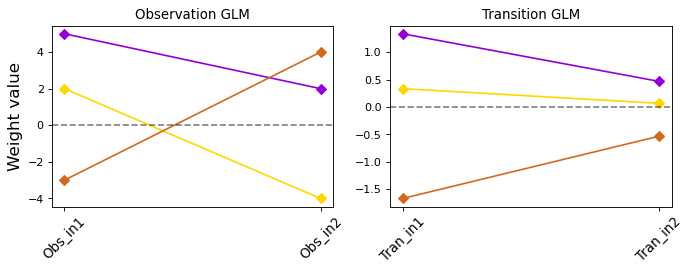

In [9]:
# Plot generative parameters:
fig = plt.figure(figsize=(10, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['darkviolet', 'gold', 'chocolate']

########### 1) Observation ##########
gen_weights_obs = gen_weights

plt.subplot(1, 2, 1)
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim_O), gen_weights_obs[k][0], marker='D',
                 color=cols[k], linestyle='-', lw=1.5)
    else:
        plt.plot(range(input_dim_O), gen_weights_obs[k][0], marker='D',
                 color=cols[k], linestyle='-', lw=1.5)

plt.yticks(fontsize=10)
plt.ylabel("Weight value", fontsize=15)
plt.xticks([0, 1], ['Obs_in1', 'Obs_in2'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("Observation GLM")

########### 2) transition ##########
gen_log_trans_mat = true_glmhmm.transitions.params[0]
gen_weights_Trans = true_glmhmm.transitions.params[1]
generative_weights_Trans = true_glmhmm.trans_weights_K(true_glmhmm.params, num_states)

plt.subplot(1, 2, 2)
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim_T), generative_weights_Trans[k], marker='D',
                 color=cols[k], linestyle='-', lw=1.5)
    else:
        plt.plot(range(input_dim_T), generative_weights_Trans[k], marker='D',
                 color=cols[k], linestyle='-', lw=1.5)

plt.yticks(fontsize=10)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.xticks([0, 1], ['Tran_in1', 'Tran_in2'], fontsize=12, rotation=45)
plt.title("Transition GLM")
plt.show()

# 3b. Sample data from the GLM-HMM

/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_60012/3193879353.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


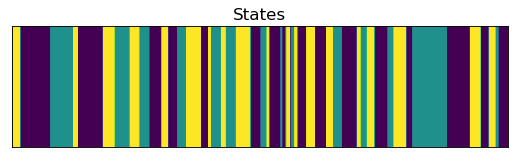

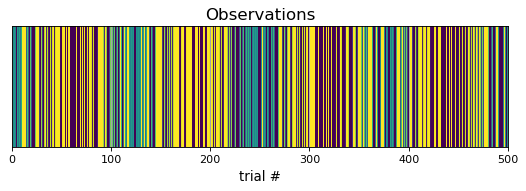

In [10]:
# Sample some data from the GLM-HMM
true_states, obs = true_glmhmm.sample(time_bins, transition_input=transition_input, observation_input=observation_input)

# Plot the data
T= 500
fig = plt.figure(figsize=(8, 2), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(true_states[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, T)
plt.yticks([])
plt.title("States", fontsize=15)

# For visualizing categorical observations, we create a Cmap. 
obs_flat = np.array([x[0] for x in obs]) #SSM initially provides categorical observations as a list of lists, and we transform them into a 1D array to facilitate plotting.
fig = plt.figure(figsize=(8, 2), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(obs_flat[None,:], aspect="auto")
plt.xlim(0, T)
plt.xlabel("trial #", fontsize=12)
plt.yticks([])
plt.grid(b=None)
plt.title("Observations", fontsize=15)
plt.show()

In [11]:
# Calculate the actual log likelihood by summing over discrete states
true_lp = true_glmhmm.log_probability(obs, transition_input=transition_input, observation_input=observation_input)
print("true_lp = " + str(true_lp))

true_lp = -2136.107121681603


# 4. Make a new HMM for fitting purpose

In this section, we instantiate a new GLM-HMM and assess its ability to recover generative parameters using Maximum Likelihood Estimation (MLE) on simulated data. MLE enables us to optimize model parameters to match the underlying data generation process, providing insights into the model's performance in emulating various scenarios.

##  EM for fitting

We employ the Expectation-Maximization (EM) method to fit the data. The EM algorithm consists of two main steps: the E-step and the M-step. The algorithm starts with an initial guess for the model parameters and iterates until the log marginal likelihood converges. During the E-step, the algorithm computes the expected value of the complete-data log-likelihood based on the model parameters estimate and the observed data (animal choices). Next, the M-Step tries to find the parameters that maximize the exepected log-likelihood.

To elaborate further, during each trial and based on the specified GLM-HMM parameters, we compute the joint probability distribution encompassing both the states and the animals' decisions (left or right). Subsequently, the log-likelihood of the model is evaluated using this joint probability distribution. This relationship can be expressed in the following manner:

$$
\begin{align}
\log \left[ p(\mathbf{Y}|\theta, \mathbf{X}^{ob}, \mathbf{X}^{tr})\right]= \log \left[ \sum_{z} 
p(\mathbf{Y}, \mathbf{Z}|\theta, \mathbf{X}^{ob}, \mathbf{X}^{tr})\right]
\end{align}
$$

In this model, as mentioned, we have defined two sets of covariates, $\mathbf{X}^{ob}={x}^{ob}_{1}, ..., {x}^{ob}_{T}$ and $\mathbf{X}^{tr}={x}^{tr}_{1}, ..., {x}^{tr}_{T}$ which coresspond to the observation and transition covariates respectively and a set of latent states as $\mathbf{Z}={z}_{1}, ..., {z}_{T} $.
The model parameters, represented as $\theta=\{ \mathbf{w}^{tr}, \mathbf{w}^{ob}, \pi\}$, encompass the initial state distribution, transition weights, and observation weights for all states.

In [12]:
glmhmm = ssm.HMM_TO(num_states, obs_dim, input_dim_T, input_dim_O, observations="input_driven_obs_diff_inputs", 
                    observation_kwargs=dict(C=num_categories), transitions="inputdrivenalt")

# 4a. Fit the new HMM
Here, we'll fit the model to simulated data. Through this fitting process, our model tries to capture the underlying dependencies that characterize the behavior of interest. This allows us to gain valuable insights into how well our model aligns with the data and its potential to generalize its findings to other cases.

In [13]:
# Fitting the model
N_iters = 200
hmm_lps = glmhmm.fit(obs, transition_input=transition_input, observation_input=observation_input, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

# 4b. Graphically represent the acquired parameters


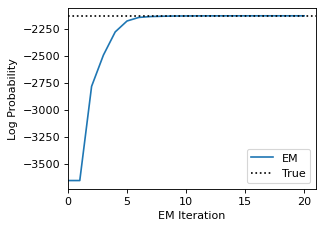

In [14]:
# Visualize the Learned Parameters
# Plot the log probabilities of the true and fit models
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(hmm_lps, label="EM")
plt.plot([0, N_iters], true_lp * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(hmm_lps))
plt.ylabel("Log Probability")
plt.show()

In [15]:
glmhmm.permute(find_permutation(true_states, glmhmm.most_likely_states(obs, transition_input=transition_input, observation_input=observation_input)))

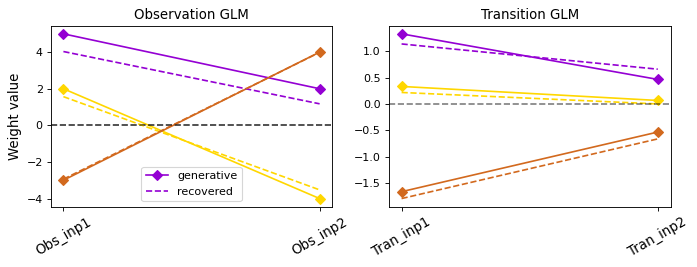

In [29]:
################## Plot generative parameters ##################
########## 1) Observation ##########
gen_weights_obs = gen_weights
recovered_weights = glmhmm.observations.params

fig = plt.figure(figsize=(10, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
for k in range(num_states):
    if k == 0:
        plt.plot(range(input_dim_O), gen_weights_obs[k][0], marker='D', color=cols[k], linestyle='-',
                 lw=1.5, label="generative")
    else:
        plt.plot(range(input_dim_O), gen_weights_obs[k][0], marker='D', color=cols[k], linestyle='-',
                 lw=1.5, label="")

plt.yticks(fontsize=10)
plt.ylabel("Weight value", fontsize=12)
plt.xticks([0, 1], ['Obs_inp1', 'Obs_inp2'], fontsize=12, rotation=30)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("Observation GLM", fontsize=12)

for k in range(num_states):
    if k == 0:
        plt.plot(range(input_dim_O), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim_O), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()

########## 2) transition ##########
gen_log_trans_mat = true_glmhmm.transitions.params[0]
gen_weights_Trans = true_glmhmm.transitions.params[1]
recovered_trans_mat = np.exp(glmhmm.transitions.params[0])

plt.subplot(1, 2, 2)
recovered_weights_Trans = glmhmm.trans_weights_K(glmhmm.params, num_states)
generative_weights_Trans = true_glmhmm.trans_weights_K(true_glmhmm.params, num_states)

for k in range(num_states): 
    if k == 0:
        plt.plot(range(input_dim_T), generative_weights_Trans[k], marker='D', color=cols[k], linestyle='-',
                 lw=1.5, label="generative")
        plt.plot(range(input_dim_T), recovered_weights_Trans[k], color=cols[k],
                 lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim_T), generative_weights_Trans[k], marker='D',
                 color=cols[k], linestyle='-', lw=1.5, label="")
        plt.plot(range(input_dim_T), recovered_weights_Trans[k], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
        
plt.yticks(fontsize=10)
plt.title("Transition GLM", fontsize=12)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.xticks([0, 1], ['Tran_inp1', 'Tran_inp2'], fontsize=12, rotation=30)
plt.show()

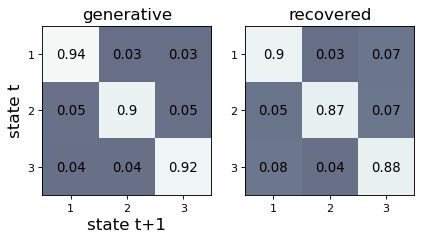

In [17]:
# transition matrix
recovered_matrix = glmhmm.Ps_matrix(data=obs, transition_input=transition_input, observation_input=observation_input) # , train_mask=train_mask)[0]
gen_trans_mat = np.exp(gen_log_trans_mat)

fig = plt.figure(figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.ylim(num_states - 0.5, -0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylabel("state t", fontsize=15)
plt.xlabel("state t+1", fontsize=15)
plt.title("generative", fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(np.mean(recovered_matrix, axis=0), vmin=-0.8, vmax=1, cmap='bone')
for i in range(np.mean(recovered_matrix, axis=0).shape[0]):
    for j in range(np.mean(recovered_matrix, axis=0).shape[1]):
        text = plt.text(j, i, str(np.around(np.mean(recovered_matrix, axis=0)[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.ylim(num_states - 0.5, -0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.title("recovered", fontsize=15)
plt.show()

# 4c. Analysis of the acquired states


In [18]:
# Get expected states
posterior_probs = [glmhmm.expected_states(data = obs, transition_input = transition_input, observation_input=observation_input)[0]]

# Determine the state with the highest posterior probability
posterior_max = np.argmax(posterior_probs[0], axis = 1)


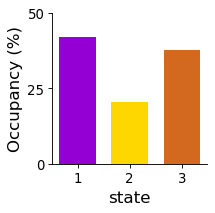

In [19]:
# calculate state fractional occupancies
_, occur_for_state = np.unique(posterior_max, return_counts=True)
sum_all = np.sum(occur_for_state)
occur_for_state = occur_for_state/sum_all

fig = plt.figure(figsize=(2.5, 2.5), dpi=80, facecolor='w', edgecolor='k')

for state, occur in enumerate(occur_for_state):
    occur_perc = occur * 100
    plt.bar(state, occur_perc, width = 0.7, color = cols[state])
    
plt.ylim((0, .6))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize=12)
plt.yticks([0, 25, 50], ['0', '25', '50'], fontsize=12)
plt.xlabel('state', fontsize=15)
plt.ylabel('Occupancy (%)', fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

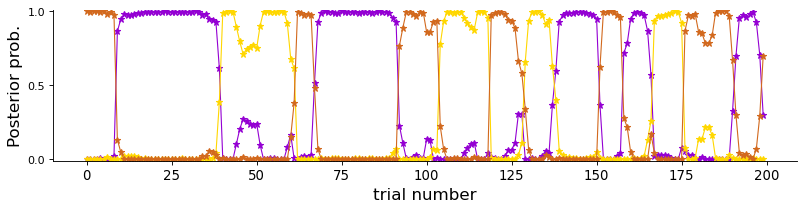

In [30]:
fig = plt.figure(figsize=(12, 2.5), dpi=80, facecolor='w', edgecolor='k')
for k in range(num_states):
    plt.plot(posterior_probs[0][0:200, k], label="State " + str(k + 1), lw=1, marker='*',
             color=cols[k])    

plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize=10)
plt.xticks(fontsize=12)
plt.xlabel("trial number", fontsize=15)
plt.ylabel("Posterior prob.", fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

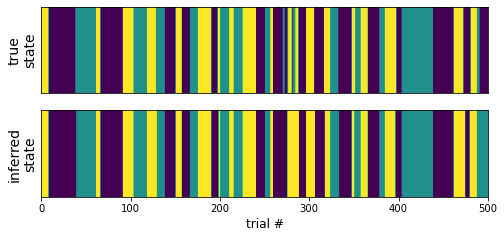

In [31]:
# plot choices and latents:
plt.figure(figsize=(8, 3.5))
time_bin= 500

plt.subplot(211)
plt.imshow(true_states[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, time_bin)
plt.ylabel("true\nstate", fontsize=14)
plt.yticks([])

plt.subplot(212)
inferred_states = glmhmm.most_likely_states(obs, transition_input=transition_input, observation_input=observation_input)
plt.imshow(inferred_states[None, :], aspect="auto")
plt.xlim(0, time_bin)
plt.ylabel("inferred\nstate", fontsize=14)
plt.yticks([])
plt.xlabel("trial #", fontsize=12)
plt.show()